## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

## Loading Data

In [3]:
gstock_data=pd.read_csv('NIFTY BANK_Data.csv');gstock_data


,Date,Open,High,Low,Close
0,06-May-22,34569.10,34797.95,34353.20,34591.20
1,05-May-22,35705.35,35934.85,35133.80,35232.85
2,04-May-22,36266.15,36309.30,35127.85,35264.55
3,02-May-22,35627.60,36235.25,35618.20,36163.75
4,29-Apr-22,36474.05,36718.80,35978.95,36088.15
...,...,...,...,...,...
3299,07-Jan-09,5416.35,5440.55,4954.00,4984.50
3300,06-Jan-09,5333.50,5448.80,5276.40,5395.30
3301,05-Jan-09,5273.45,5371.10,5273.45,5359.40
3302,02-Jan-09,5154.20,5258.65,5103.60,5195.10


In [5]:

gstock_data['Date'] = pd.to_datetime(gstock_data['Date'], format='%d-%b-%y')
gstock_data = gstock_data.sort_values(by='Date',ascending=True)
gstock_data['Date'] = gstock_data['Date'].dt.strftime('%d-%m-%Y') 
gstock_data.set_index('Date',drop=True,inplace=True) 
gstock_data.head(15)

,Open,High,Low,Close
Date,,,,
01-01-2009,5019.20,5135.15,5019.20,5116.5
02-01-2009,5154.20,5258.65,5103.60,5195.1
05-01-2009,5273.45,5371.10,5273.45,5359.4
06-01-2009,5333.50,5448.80,5276.40,5395.3
07-01-2009,5416.35,5440.55,4954.00,4984.5
09-01-2009,4891.80,5056.95,4840.00,4906.7
12-01-2009,4862.00,4881.50,4612.75,4698.0
13-01-2009,4700.25,4764.15,4605.65,4661.7
14-01-2009,4684.30,4819.50,4682.10,4751.1


In [25]:
data = gstock_data.drop(['Open', 'High', 'Low'], axis = 1); data

,Close
Date,
01-01-2009,5116.50
02-01-2009,5195.10
05-01-2009,5359.40
06-01-2009,5395.30
07-01-2009,4984.50
...,...
29-04-2022,36088.15
02-05-2022,36163.75
04-05-2022,35264.55


In [26]:
date = list(gstock_data.index)

## Data Loading and train-test splitting

In [27]:
def load_data(stock, look_back):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.1*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    date_train = date[5:train_set_size+5]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    date_test = date[train_set_size+5:-1]
    return [x_train, y_train, date_train, x_test, y_test, date_test]
  

In [28]:
sc = MinMaxScaler()
data = sc.fit_transform(data)
x_train, y_train, date_train, x_test, y_test, date_test = load_data(data, 6)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('date_train length = ', len(date_train))
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
print('date_test length = ', len(date_test))

x_train.shape =  (2968, 5, 1)
y_train.shape =  (2968, 1)
date_train length =  2968
x_test.shape =  (330, 5, 1)
y_test.shape =  (330, 1)
date_test length =  330


In [29]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


## Building the model

In [30]:

input_dim = 1
hidden_dim = 5
num_layers = 4 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 5, num_layers=4, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)
18
torch.Size([20, 1])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
torch.Size([20, 5])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
torch.Size([20, 5])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
torch.Size([20, 5])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
torch.Size([1, 5])
torch.Size([1])


In [ ]:
sum(i.numel() for i in model.parameters())  ## no. of parameters

## Training the model

In [32]:
# Train model
#####################
num_epochs = 850
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =5


for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.037645574659109116
Epoch  20 MSE:  0.03756542503833771
Epoch  30 MSE:  0.03696620091795921
Epoch  40 MSE:  0.02283462882041931
Epoch  50 MSE:  0.0034888230729848146
Epoch  60 MSE:  0.0018281386001035571
Epoch  70 MSE:  0.0009373808279633522
Epoch  80 MSE:  0.0005762772052548826
Epoch  90 MSE:  0.0003676996857393533
Epoch  100 MSE:  0.00027913536177948117
Epoch  110 MSE:  0.00027315696934238076
Epoch  120 MSE:  0.00024185092479456216
Epoch  130 MSE:  0.00036541346344165504
Epoch  140 MSE:  0.0002414615883026272
Epoch  150 MSE:  0.0002266055962536484
Epoch  160 MSE:  0.0002226185315521434
Epoch  170 MSE:  0.00022099936904851347
Epoch  180 MSE:  0.00021492346422746778
Epoch  190 MSE:  0.00021401407138910145
Epoch  200 MSE:  0.00021581522014457732
Epoch  210 MSE:  0.00040280731627717614
Epoch  220 MSE:  0.00021508762438315898
Epoch  230 MSE:  0.0002113647642545402
Epoch  240 MSE:  0.00021054796525277197
Epoch  250 MSE:  0.00020974257495254278
Epoch  260 MSE:  0.0002105590

## Testing

In [33]:

y_test_pred = model(x_test)
y_train_pred = model(x_train)



# invert predictions
y_train_pred = sc.inverse_transform(y_train_pred.data.numpy())
y_train = sc.inverse_transform(y_train.data.numpy())
y_test_pred = sc.inverse_transform(y_test_pred.data.numpy())
y_test = sc.inverse_transform(y_test.data.numpy())

# calculate root mean squared error
trainScore = sqrt(mse(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mse(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 469.53 RMSE
Test Score: 2556.62 RMSE


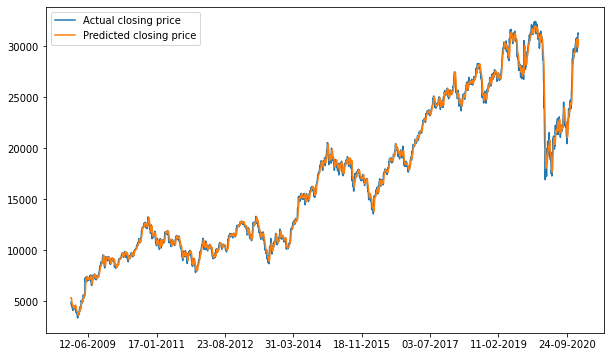

In [38]:
plt.figure(figsize=(10,6))
plt.plot(y_train, label = 'Actual closing price')
plt.plot(y_train_pred, label = 'Predicted closing price')
index = np.arange(100,2928,400)

plt.xticks(index, labels = date_train[100:2928:400])
plt.legend()
plt.show()

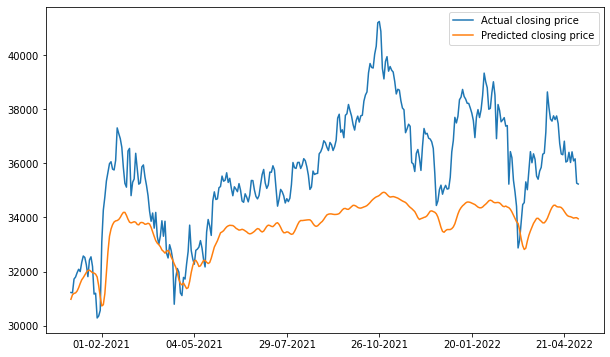

In [39]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label = 'Actual closing price')
plt.plot(y_test_pred, label = 'Predicted closing price')
index = np.arange(20,330,60)
plt.xticks(index, labels = date_test[20:330:60])
plt.legend()
plt.show()